# Data Preprocessing 
---

### 개요
* Data를 분석하기 위해서는 다음과 같은 조건이 필요함
    * Data 사이 분석을 위해 통일된 value 값의 크기  
        e.g.) 전력량 값과 온도 값 사이 비교/분석을 위해서는 서로 비슷한 크기로 data의 value 값을 조정해줘야 할 필요가 있음
    * 일정한 time_stamp 간격   
    
---    
* 아래는 분석 전 data에 필요한 조건을 충족하기 위한 과정을 만족시키기 위한 **preprocessing** 과정임
<img src="https://raw.githubusercontent.com/jhyun0919/EnergyData_jhyun/master/docs/images/%EC%8A%A4%ED%81%AC%EB%A6%B0%EC%83%B7%202016-05-16%20%EC%98%A4%ED%9B%84%202.06.23.jpg" alt="Drawing" style="width: 800px;"/>

---
* 참고 )   
      배포한 모듈에 대한 변경사항이 있는 경우 반드시 다음 명령어를 실행하여 변경사항이 배포된 버전에 반영되도록 하자
```
>>> python setup.py sdist
>>> python setup.py install
```

---
* data-preprocessing 과정에 필요한 module들을 import 하자 

In [1]:
from utils import Preprocess
from utils import FileIO
from utils import GlobalParameter
from utils import Graph
%matplotlib inline
import os
import math

---
* 모든 data file은 GlobalParameter.Repository_Path의 경로 아래에 저장하고 불러온다
* 다음 과정은 주어진 경로 아래에 저장된 특정 file을 지정하고 확인해보는 과정이다

In [2]:
file_path = os.path.join(GlobalParameter.Repository_Path, 'VTT')
file_name = 'VTT_GW1_HA10_VM_EP_KV_K.bin'
file_path = os.path.join(file_path, file_name)

file_path

'/Users/JH/Documents/GitHub/EnergyData_jhyun/repository/VTT/VTT_GW1_HA10_VM_EP_KV_K.bin'

---
* 해당 file의 data를 graph를 통해 확인해보자

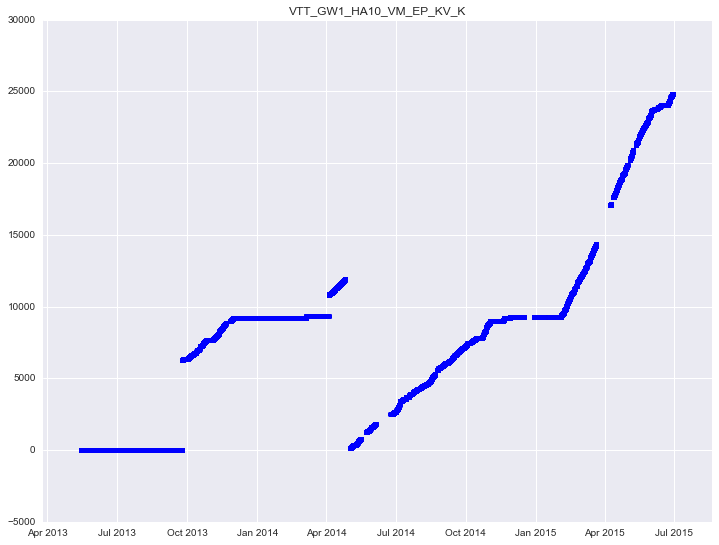

In [3]:
Graph.Show.raw_data2graph(file_path)

---
* 해당 file의 data를 직접 출력하여 확인해 보면 다음과 같은 문제점을 확인 가능하다


In [4]:
data_dictionary = FileIO.Load.unpickling(file_path)

data_dictionary

{'file_name': 'VTT_GW1_HA10_VM_EP_KV_K',
 'ts': array([[datetime.datetime(2013, 5, 15, 10, 37, 23), 23, 37, ..., 2, 15, 5],
        [datetime.datetime(2013, 5, 15, 10, 42, 30), 30, 42, ..., 2, 15, 5],
        [datetime.datetime(2013, 5, 15, 10, 47, 30), 30, 47, ..., 2, 15, 5],
        ..., 
        [datetime.datetime(2015, 6, 30, 0, 46, 32), 32, 46, ..., 1, 30, 6],
        [datetime.datetime(2015, 6, 30, 0, 51, 32), 32, 51, ..., 1, 30, 6],
        [datetime.datetime(2015, 6, 30, 0, 56, 32), 32, 56, ..., 1, 30, 6]], dtype=object),
 'value': array([     0.,      0.,      0., ...,  24826.,  24826.,  24826.])}

##### graph를 통해 보면 문제가 없는 data로 보일 수 있지만, 직접 출력하여 확인하면 다음과 같은 문제점들을 가지고 있음

* 다른 file의 data 들과 통일되지 않은 value 값의 크기 ( **scaling** 필요 )  
* 일정하지 않은 time stamp 간격 ( **ts_scaling, interpolation** 필요 )

##### 이를 해결하기 위해 preprocessing 과정이 반드시 필요하다

---
### Step 01. Time Stamp Scaling (Equalize Time Interval) 

* ts_scaling을 통해 data의 모든 ts가 GlobalParameter.Time_Interval의 일정한 간격으로 조정된다
* 간격의 크기는 GlobalParameter.Time_Interval에서 확인/변경 가능하다

##### [ ts_scaling strategy ]
* 일정한 간격으로 time stamp를 조정함
* 어느 time stamp에 해당하는 value는 해당 구간 안의 value 값들의 평균값으로 지정

* 아래는 GlobalParamter에서 지정된 Time_Interval을 보여주는 것이며 단위는 minute 이다

In [5]:
# check Normalization_Interval (minute)
GlobalParameter.Time_Interval

15

##### 일정한 간격으로 ts 값을 조정하다보면 해당 간격에 기록된 value 값이 없는 경우가 발생한다
* GlobalParameter.Normalization_Interval 사이 해당하는 value 값이 없으면 해당 값에 **NaN** 을 넣어주자

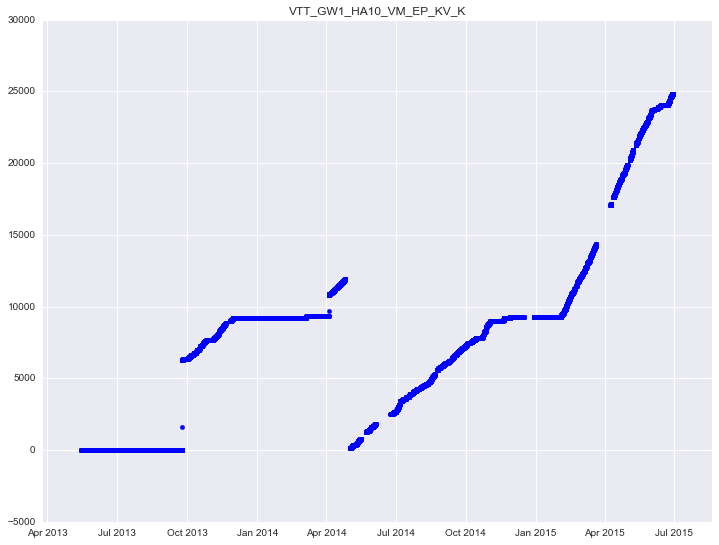

In [6]:
data_dictionary = Preprocess.ts_scaling(data_dictionary)

Graph.Show.dictionary2graph(data_dictionary)

* 직접 출력하여 ts와 value 값을 보면 다음과 같은 문제점을 확인 가능하다
    * 다른 file의 data 들과 통일되지 않은 value 값의 크기 ( scaling 필요 )
    * <s>일정하지 않은 time stamp 간격</s> 
        * **ts_scaling** 통해 ts 값이 일정한 간격으로 조정 되었음
    * **ts_scaling** 과정에 **NaN**이 발생함

In [7]:
data_dictionary

{'file_name': 'VTT_GW1_HA10_VM_EP_KV_K',
 'ts': array([datetime.datetime(2013, 5, 15, 10, 30),
        datetime.datetime(2013, 5, 15, 10, 45),
        datetime.datetime(2013, 5, 15, 11, 0), ...,
        datetime.datetime(2015, 6, 30, 0, 15),
        datetime.datetime(2015, 6, 30, 0, 30),
        datetime.datetime(2015, 6, 30, 0, 45)], dtype=object),
 'value': array([     0.,      0.,      0., ...,  24826.,  24826.,  24826.])}

* ts_scaling 도중 발생한 NaN를 직접 확인

In [8]:
nancounter = 0

for line in data_dictionary['value']:
    if math.isnan(line):
        nancounter += 1
        
nancounter

11472

---
### Step 02. Interpolation
: interval_equalization과정 발생한 NaN을 처리하기 위한 과정 

* ts와 value가 1:1 매칭이 되도록 하기 위한 과정
* interpolation을 통해 기록된 값이 없는 경우(NaN)에 적절한 값을 배정하여 준다

##### [ interpolation strategy ]
* 해당 ts에 해당하는 value가 NaN일 경우, 일차 선형방정식을 대입하여 interpolation 될 값을 찾는다

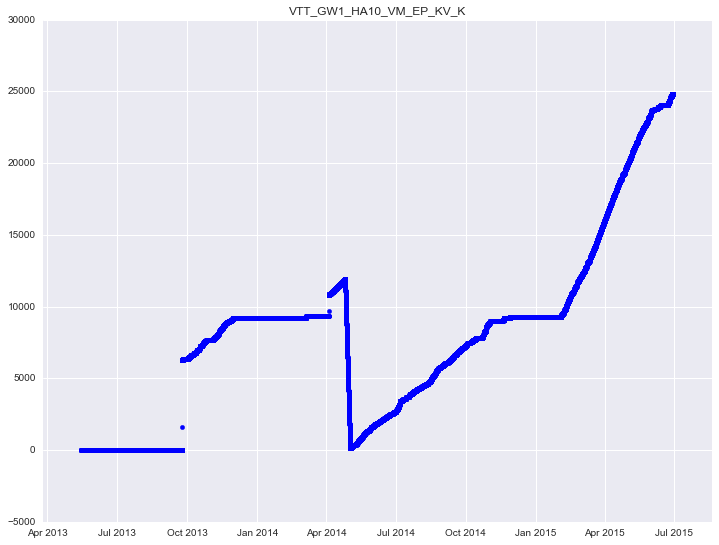

In [9]:
data_dictionary = Preprocess.interpolation(data_dictionary)

Graph.Show.dictionary2graph(data_dictionary)

In [10]:
data_dictionary

{'file_name': 'VTT_GW1_HA10_VM_EP_KV_K',
 'ts': array([datetime.datetime(2013, 5, 15, 10, 30),
        datetime.datetime(2013, 5, 15, 10, 45),
        datetime.datetime(2013, 5, 15, 11, 0), ...,
        datetime.datetime(2015, 6, 30, 0, 15),
        datetime.datetime(2015, 6, 30, 0, 30),
        datetime.datetime(2015, 6, 30, 0, 45)], dtype=object),
 'value': array([     0.,      0.,      0., ...,  24826.,  24826.,  24826.])}

* interpolation 이후 NaN 제거 여부를 직접 확인

In [11]:
nancounter = 0

for line in data_dictionary['value']:
    if math.isnan(line):
        nancounter += 1
        
nancounter

0

* 직접 출력하여 ts와 value 값을 보면 다음과 같은 문제점을 확인 가능하다
    * 다른 file의 data 들과 통일되지 않은 value 값의 크기 ( scaling 필요 )
    * <s>일정하지 않은 time stamp 간격</s> 
        * **interval_equalization** 통해 ts 값이 일정한 간격으로 조정 되었음
    * <s>**interval_equalization** 과정에 **NaN**이 발생함</s>
        * **interpolation**을 통해 NaN 제거

---
### Step 03. Scaling
: 다른 종류의 data 끼리 비교&분석을 하기위한 크기를 통일시키는 과정
* scaling은 data의 모든 value 값의 분포가 평균 0, 분산 1이 되도록 만드는 과정  

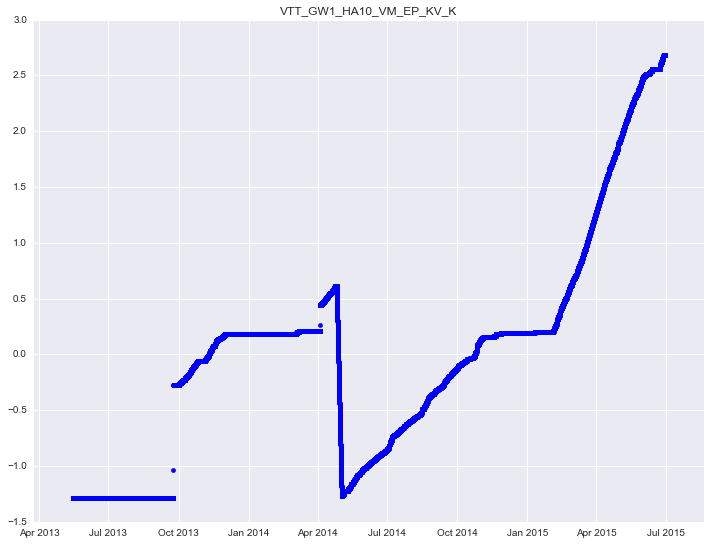

In [12]:
data_dictionary = Preprocess.scaling(data_dictionary)

Graph.Show.dictionary2graph(data_dictionary)

In [13]:
data_dictionary

{'file_name': 'VTT_GW1_HA10_VM_EP_KV_K',
 'ts': array([datetime.datetime(2013, 5, 15, 10, 30),
        datetime.datetime(2013, 5, 15, 10, 45),
        datetime.datetime(2013, 5, 15, 11, 0), ...,
        datetime.datetime(2015, 6, 30, 0, 15),
        datetime.datetime(2015, 6, 30, 0, 30),
        datetime.datetime(2015, 6, 30, 0, 45)], dtype=object),
 'value': array([-1.28467242, -1.28467242, -1.28467242, ...,  2.68035121,
         2.68035121,  2.68035121])}

* 직접 출력하여 ts와 value 값을 보면 다음과 같은 문제점을 확인 가능하다
    * <s>다른 file의 data 들과 통일되지 않은 value 값의 크기 ( scaling 필요 )</s>
        * **scaling**을 통해 data의 크기 조정
    * <s>일정하지 않은 time stamp 간격</s> 
        * **interval_equalization** 통해 ts 값이 일정한 간격으로 조정 되었음
    * <s>**interval_equalization** 과정에 **NaN**이 발생함</s>
        * **interpolation**을 통해 NaN 제거

---
##### 위 preprocessing 과정을 통해 아래와 같은 조건을 만족시켜 data를 분석하기 위한 준비과정을 완료하였음
* 일정한 크기로의 value 값을 조정 ( via **scaling** )
* 일정한 간격의 time_stamp ( via **interval_equalization** ) 
* 모든 time_stamp에 value 값이 1:1 매칭 ( via **interpolation** )